<a href="https://colab.research.google.com/github/landwinner/Dive-into-DL-PyTorch/blob/master/%E2%80%9Cimageseg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

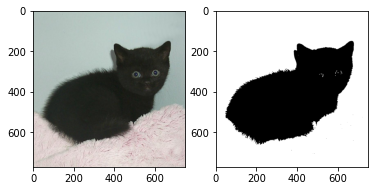

(50, 50, 3)
Original cluster by vq clustering:
 [0 0 0 ... 0 0 0]


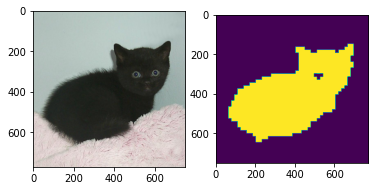

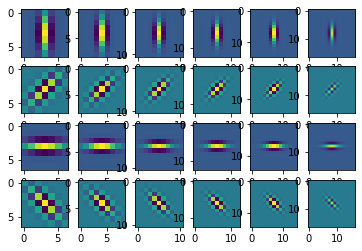

用于绘制滤波效果


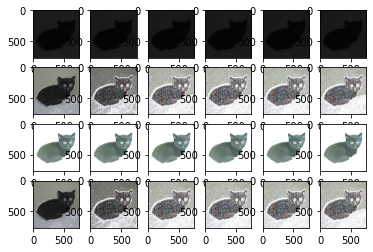

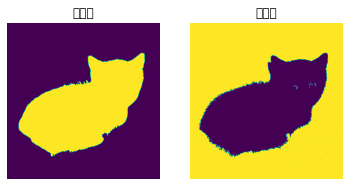

（1）DICE计算结果，      DSI       = 0.0009461
（2）VOE计算结果，       VOE       = 0.7506
（3）RVD计算结果，       RVD       = 1.202
（4）Precision计算结果， Precision = 0.0006879
（5）Recall计算结果，    Recall    = 0.001515


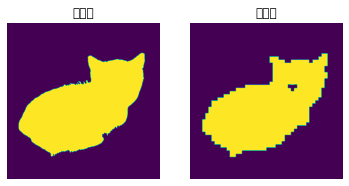

（1）DICE计算结果，      DSI       = 0.9734
（2）VOE计算结果，       VOE       = -0.01499
（3）RVD计算结果，       RVD       = -0.01488
（4）Precision计算结果， Precision = 0.9808
（5）Recall计算结果，    Recall    = 0.9662


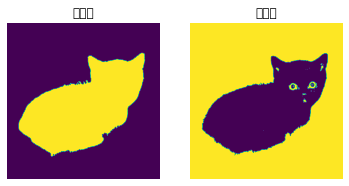

（1）DICE计算结果，      DSI       = 0.02423
（2）VOE计算结果，       VOE       = 0.7845
（3）RVD计算结果，       RVD       = 1.291
（4）Precision计算结果， Precision = 0.0174
（5）Recall计算结果，    Recall    = 0.03987


In [6]:
# import os
# os.chdir("/content/sample_data")
import scipy.cluster.hierarchy as sch
import PIL.Image as image
from sklearn.cluster import KMeans
from pylab import  *
from PIL import Image
import cv2
from scipy.cluster.vq import *
import scipy
import matplotlib.pylab as plt
import numpy as np

'''方法1'''
def load_data(file_path):
    f = open(file_path,'rb') #二进制打开
    data = []
    img = image.open(f) #以列表形式返回图片像素值
    m,n = img.size #活的图片大小
    for i in range(m):
        for j in range(n):  #将每个像素点RGB颜色处理到0-1范围内并存放data
            x,y,z = img.getpixel((i,j))
            data.append([x/256.0,y/256.0,z/256.0])
    f.close()
    return np.mat(data),m,n #以矩阵型式返回data，图片大小
def putpixel(img,n_clusters,signal):
  img_data,row,col = load_data(img)
  if signal==1:
    label = KMeans(n_clusters=n_clusters).fit_predict(img_data)  #聚类中心的个数为3
  else:
    # label = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(img_data)  #层次聚类聚类中心的个数为3

    #1. 层次聚类
    #生成点与点之间的距离矩阵,这里用的欧氏距离:
    disMat = sch.distance.pdist(img_data,'euclidean')
    #进行层次聚类:
    Z=sch.linkage(disMat,method='average')
    #将层级聚类结果以树状图表示出来并保存为plot_dendrogram.png
    P=sch.dendrogram(Z)
    plt.savefig('plot_dendrogram.png')
    #根据linkage matrix Z得到聚类结果:
    label= sch.fcluster(Z,t=1,criterion='inconsistent')
    print("Original cluster by hierarchy clustering:\n",cluster)


  label = label.reshape([row,col],)    #聚类获得每个像素所属的类别
  pic_new = image.new("L",(row,col))  #创建一张新的灰度图保存聚类后的结果
  for i in range(row):    #根据所属类别向图片中添加灰度值
      for j in range(col):
          pic_new.putpixel((i,j),int(256/(label[i][j]+1)))
  im = np.array(image.open(img))
  
  plt.subplot(1,2,1)
  plt.imshow(im)
  plt.subplot(1,2,2)
  plt.imshow(pic_new, cmap = "gray")
  plt.savefig("/content/sample_data/result/putpixelres.jpg")
  plt.show()
  pic_new.save("/content/sample_data/output/putpixel.jpg", "JPEG")


'''方法2'''
'''创建用于归一化割的矩阵，其中 sigma_d 和 sigma_g 是像素距离和像素相似性的权重参数'''
def ncut_graph_matrix(im,sigma_d=1e2,sigma_g=1e-2):
     """ 创建用于归一化割的矩阵，其中 sigma_d 和 sigma_g 是像素距离和像素相似性的权重参数 """
     m,n = im.shape[:2]
     N = m*n
     # 归一化，并创建 RGB 或灰度特征向量
     if len(im.shape)==3:
         for i in range(3):
            im[:,:,i] = im[:,:,i] / im[:,:,i].max()

         print(im.shape)
         vim = im.reshape((-1,3))
     else:
         im = im / im.max()
         vim = im.flatten()
     # x,y 坐标用于距离计算
     xx,yy = np.meshgrid(range(n),range(m))
     x,y = xx.flatten(),yy.flatten()
     # 创建边线权重矩阵
     W = np.zeros((N,N),'f')
     for i in range(N):
         for j in range(i,N):
             d = (x[i]-x[j])**2 + (y[i]-y[j])**2
             W[i,j] = W[j,i] = exp(-1.0*sum((vim[i]-vim[j])**2)/sigma_g) * exp(-d/sigma_d)
     return W
'''从相似性矩阵进行谱聚类'''
def cluster(S,k,ndim,signal):
     """ 从相似性矩阵进行谱聚类 """
     # 检查对称性
     if sum(abs(S-S.T)) > 1e-10:
         print('not symmetric')
     # 创建拉普拉斯矩阵
     rowsum = sum(abs(S),axis=0)
     D = np.diag(1 / np.sqrt(rowsum + 1e-6))
     L = np.dot(D,np.dot(S,D))
     # 计算 L 的特征向量
     U,sigma,V = np.linalg.svd(L)
     # 从前 ndim 个特征向量创建特征向量
     # 堆叠特征向量作为矩阵的列
     features = np.array(V[:ndim]).T
     # K-means 聚类
     #将features做归一化处理
     features = whiten(features)
     if signal==1:
        centroids,distortion = kmeans(features,k)
        #使用vq函数根据聚类中心对所有数据进行分类,vq的输出也是两维的,[0]表示的是所有数据的label
        code,distance = vq(features,centroids)
        print("Original cluster by vq clustering:\n",code)
     else:
        #1. 层次聚类
        #生成点与点之间的距离矩阵,这里用的欧氏距离:
        disMat = sch.distance.pdist(features,'euclidean')
        #进行层次聚类:
        Z=sch.linkage(disMat,method='average')
        #将层级聚类结果以树状图表示出来并保存为plot_dendrogram.png
        P=sch.dendrogram(Z)
        plt.savefig('plot_dendrogram.png')
        #根据linkage matrix Z得到聚类结果:
        code= sch.fcluster(Z,t=1,criterion='inconsistent')
        print("Original cluster by hierarchy clustering:\n",cluster)
     return code
def paint(img,k,ndim,signal):
  im = array(Image.open(img))
  m,n = im.shape[:2]
  wid = 50
  # 调整图像的尺寸大小为 (wid,wid)
  # rim = np.array(Image.fromarray(im).resize((wid,wid)))
  rim=cv2.resize(im,(wid,wid),interpolation=cv2.INTER_LINEAR)
  # rim = imresize(im,(wid,wid),interp='bilinear')
  rim = array(rim,'f')
  # 创建归一化割矩阵
  A =ncut_graph_matrix(rim,sigma_d=1,sigma_g=1e-2)
  # 聚类
  code =cluster(S=A,k=k,ndim=ndim,signal=signal)
  # 变换到原来的图像大小
  # code=array(code.reshape(wid,wid))
  # codeim=cv2.resize(code,(m,n),interpolation=cv2.INTER_NEAREST)
  codeim = np.array(Image.fromarray(code.reshape(wid,wid)).resize((m,n)))
  cc=codeim
  cv2.imwrite("/content/sample_data/output/paint.jpg",codeim*255)
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(im)
  plt.subplot(1,2,2)
  plt.imshow(codeim)
  plt.savefig("/content/sample_data/result/paintres.jpg")
  plt.show()
  

'''方法3'''
#构建Gabor滤波器
def build_filters():
     filters = []
     ksize = [7,9,11,13,15,17] # gabor尺度，6个
     lamda = np.pi/2.0         # 波长
     for theta in np.arange(0, np.pi, np.pi / 4): #gabor方向，0°，45°，90°，135°，共四个
         for K in range(6):
             kern = cv2.getGaborKernel((ksize[K], ksize[K]), 1.0, theta, lamda, 0.5, 0, ktype=cv2.CV_32F)
             kern /= 1.5*kern.sum()
             filters.append(kern)
     plt.figure(1)

     #用于绘制滤波器
     for temp in range(len(filters)):
         plt.subplot(4, 6, temp + 1)
         plt.imshow(filters[temp])
     
     plt.savefig("/content/sample_data/result/filterres.jpg")
     plt.show()
     return filters
#Gabor特征提取
def getGabor(img,filters,imgpath):
    f = open(imgpath,'rb') #二进制打开
    op = Image.open(f) #以列表形式返回图片像素值
    m,n = op.size #活的图片大小


    res = [] #滤波结果
    for i in range(len(filters)):
        # res1 = process(img, filters[i])
        accum = np.zeros_like(img)
        for kern in filters[i]:
            fimg = cv2.filter2D(img, cv2.CV_8UC1, kern)
            accum = np.maximum(accum, fimg, accum)
        res.append(np.asarray(accum))

    #用于绘制滤波效果
    plt.figure(2)
    print("用于绘制滤波效果")
    for temp in range(len(res)):
        plt.subplot(4,6,temp+1)
        plt.imshow(res[temp])
    
    plt.savefig("/content/sample_data/result/gaborres.jpg")
    plt.show()
    # plt.figure(3)
    # print("用于绘制聚类")
    # for temp in range(len(res)):

    #     features=res[temp]
    #     m,n=features.shape[:2]
    #     wid = 50
    #     rim=cv2.resize(features,(wid,wid),interpolation=cv2.INTER_LINEAR)
    #     rim = array(rim,'f')
    #     # 创建归一化割矩阵
    #     A =ncut_graph_matrix(rim,sigma_d=1,sigma_g=1e-2)
    #     # 聚类
    #     code =cluster(S=A,k=2,ndim=3,signal=1)
    #     # 变换到原来的图像大小
    #     codeim = np.array(Image.fromarray(code.reshape(wid,wid)).resize((m,n)))
    #     plt.subplot(4,6,temp+1)
    #     if temp==4:
    #       break
    #     plt.imshow(codeim)
    # plt.show()
    return res  #返回滤波结果,结果为24幅图，按照gabor角度排列

'''评估'''
# 计算DICE系数，即DSI
def calDSI(binary_GT,binary_R):
    row, col = binary_GT.shape  # 矩阵的行与列
    DSI_s,DSI_t = 0,0
    for i in range(row):
        for j in range(col):
            if binary_GT[i][j] == 255 and binary_R[i][j] == 255:
                DSI_s += 1
            if binary_GT[i][j] == 255:
                DSI_t += 1
            if binary_R[i][j]  == 255:
                DSI_t += 1
    DSI = 2*DSI_s/DSI_t
    # print(DSI)
    return DSI
 
# 计算VOE系数，即VOE
def calVOE(binary_GT,binary_R):
    row, col = binary_GT.shape  # 矩阵的行与列
    VOE_s,VOE_t = 0,0
    for i in range(row):
        for j in range(col):
            if binary_GT[i][j] == 255:
                VOE_s += 1
            if binary_R[i][j]  == 255:
                VOE_t += 1
    VOE = 2*(VOE_t - VOE_s)/(VOE_t + VOE_s)
    return VOE
 
# 计算RVD系数，即RVD
def calRVD(binary_GT,binary_R):
    row, col = binary_GT.shape  # 矩阵的行与列
    RVD_s,RVD_t = 0,0
    for i in range(row):
        for j in range(col):
            if binary_GT[i][j] == 255:
                RVD_s += 1
            if binary_R[i][j]  == 255:
                RVD_t += 1
    RVD = RVD_t/RVD_s - 1
    return RVD
 
# 计算Prevision系数，即Precison
def calPrecision(binary_GT,binary_R):
    row, col = binary_GT.shape  # 矩阵的行与列
    P_s,P_t = 0,0
    for i in range(row):
        for j in range(col):
            if binary_GT[i][j] == 255 and binary_R[i][j] == 255:
                P_s += 1
            if binary_R[i][j]   == 255:
                P_t += 1
 
    Precision = P_s/P_t
    return Precision
 
# 计算Recall系数，即Recall
def calRecall(binary_GT,binary_R):
    row, col = binary_GT.shape  # 矩阵的行与列
    R_s,R_t = 0,0
    for i in range(row):
        for j in range(col):
            if binary_GT[i][j] == 255 and binary_R[i][j] == 255:
                R_s += 1
            if binary_GT[i][j]   == 255:
                R_t += 1
 
    Recall = R_s/R_t
    return Recall


def evaluate(firstpath,secondpath,thirdpath):
    imgData,row,col = load_data(firstpath)
    
    import re
    subject = secondpath
    result = re.findall(r'[^\\/:*?"<>|\r\n]+$', subject)
    # step 1：读入图像，并灰度化
    img_GT = cv2.imread(thirdpath,0)
    img_R  = cv2.imread(secondpath,0)
    img_R=cv2.resize(img_R,(row,col),interpolation=cv2.INTER_LINEAR)
    # imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)   # 灰度化
    # img_GT = img_GT[:,:,[2, 1, 0]]
    # img_R  = img_R[:,: [2, 1, 0]]

    # step2：二值化
    # 利用大律法,全局自适应阈值 参数0可改为任意数字但不起作用
    ret_GT, binary_GT = cv2.threshold(img_GT, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    ret_R, binary_R   = cv2.threshold(img_R, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # step 3： 显示二值化后的分割图像与真值图像
    plt.figure()
    plt.subplot(121),plt.imshow(binary_GT),plt.title('真值图')
    plt.axis('off')
    plt.subplot(122),plt.imshow(binary_R),plt.title('分割图')
    plt.axis('off')
    

    plt.savefig("/content/sample_data/result/"+result[-1][:-4]+"res.jpg")
    plt.show()

    # step 4：计算DSI
    print('（1）DICE计算结果，      DSI       = {0:.4}'.format(calDSI(binary_GT,binary_R)))  # 保留四位有效数字
    # step 5：计算VOE
    print('（2）VOE计算结果，       VOE       = {0:.4}'.format(calVOE(binary_GT,binary_R)))
    # step 6：计算RVD
    print('（3）RVD计算结果，       RVD       = {0:.4}'.format(calRVD(binary_GT,binary_R)))
    # step 7：计算Precision
    print('（4）Precision计算结果， Precision = {0:.4}'.format(calPrecision(binary_GT,binary_R)))
    # step 8：计算Recall
    print('（5）Recall计算结果，    Recall    = {0:.4}'.format(calRecall(binary_GT,binary_R)))




if __name__ == '__main__':

    '''方法1'''
    putpixel('/content/sample_data/black_kitten_star.jpg',2,1)
    # 全图做层次聚类 内存爆满
    # putpixel('2.jpg',2,0)

    '''方法2'''
    paint('/content/sample_data/black_kitten_star.jpg',2,3,1)
    # 做完特征分解，可以使用层次聚类
    # paint('2.jpg',2,3,0)

    '''方法3'''
    
    imgpath = '/content/sample_data/black_kitten_star.jpg'
    filters = build_filters()
    img = cv2.imread(imgpath)
    res=getGabor(img,filters,imgpath)

    cv2.imwrite("/content/sample_data/output/getgabor.jpg",res[12])


    import warnings
    warnings.filterwarnings('ignore')
    '''评估'''
    evaluate(firstpath="/content/sample_data/black_kitten_star.jpg",
    secondpath="/content/sample_data/output/putpixel.jpg",
    thirdpath="/content/sample_data/black_kitten_star.png")

    evaluate(firstpath="/content/sample_data/black_kitten_star.jpg",
    secondpath="/content/sample_data/output/paint.jpg",
    thirdpath="/content/sample_data/black_kitten_star.png")

    evaluate(firstpath="/content/sample_data/black_kitten_star.jpg",
    secondpath="/content/sample_data/output/getgabor.jpg",
    thirdpath="/content/sample_data/black_kitten_star.png")



